In [1]:
import pandas as pd

# Load datasets
solar = pd.read_csv("installed-solar-pv-capacity.csv")
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
pop1 = pd.read_csv("population (1).csv")
pop2 = pd.read_csv("population (2).csv")

# Show first 5 rows
print("🔆 Solar:")
print(solar.head(), "\n")

print("🌬️ Wind:")
print(wind.head(), "\n")

print("👥 Population 1:")
print(pop1.head(), "\n")

print("👥 Population 2:")
print(pop2.head())


🔆 Solar:
        Entity Code  Year  Solar capacity (total) (GW)
0  Afghanistan  AFG  2009                     0.000002
1  Afghanistan  AFG  2010                     0.000102
2  Afghanistan  AFG  2011                     0.000120
3  Afghanistan  AFG  2012                     0.016122
4  Afghanistan  AFG  2013                     0.016843 

🌬️ Wind:
        Entity Code  Year  Wind capacity (total) (GW)
0  Afghanistan  AFG  2012                      0.0001
1  Afghanistan  AFG  2013                      0.0001
2  Afghanistan  AFG  2014                      0.0001
3  Afghanistan  AFG  2015                      0.0001
4  Afghanistan  AFG  2016                      0.0001 

👥 Population 1:
         Series Name  Series Code    Country Name Country Code 1990 [YR1990]  \
0  Population, total  SP.POP.TOTL     Afghanistan          AFG      12045660   
1  Population, total  SP.POP.TOTL         Albania          ALB       3286542   
2  Population, total  SP.POP.TOTL         Algeria          DZA      

In [2]:
# Keep only the necessary columns
pop = pop1.drop(columns=["Series Name", "Series Code"])

# Melt the wide format into long format
pop_long = pop.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")

# Clean Year column (remove '[YRxxxx]')
pop_long['Year'] = pop_long['Year'].str.extract(r'(\d{4})').astype(int)
pop_long['Population'] = pd.to_numeric(pop_long['Population'], errors='coerce')

# Preview
pop_long.head()


,Country Name,Country Code,Year,Population
0,Afghanistan,AFG,1990,12045660.0
1,Albania,ALB,1990,3286542.0
2,Algeria,DZA,1990,25375810.0
3,American Samoa,ASM,1990,46640.0
4,Andorra,AND,1990,52597.0


In [3]:
# Rename for clarity
solar.rename(columns={"Entity": "Country", "Code": "Country Code", "Year": "Year", 
                      "Solar capacity (total) (GW)": "Solar_GW"}, inplace=True)

wind.rename(columns={"Entity": "Country", "Code": "Country Code", "Year": "Year", 
                     "Wind capacity (total) (GW)": "Wind_GW"}, inplace=True)

# Merge solar and wind
renewable = pd.merge(solar, wind[["Country Code", "Year", "Wind_GW"]], on=["Country Code", "Year"], how="outer")

# Merge with population
data = pd.merge(renewable, pop_long, on=["Country Code", "Year"], how="left")

# Calculate per capita capacity (in kW per person)
data["Total_GW"] = data["Solar_GW"].fillna(0) + data["Wind_GW"].fillna(0)
data["PerCapita_kW"] = (data["Total_GW"] * 1e6) / data["Population"]

# Drop missing values
data_clean = data.dropna(subset=["PerCapita_kW"])

# Preview
data_clean.sort_values(by="PerCapita_kW", ascending=False).head(10)



,Country,Country Code,Year,Solar_GW,Wind_GW,Country Name,Population,Total_GW,PerCapita_kW
2751,Netherlands,NLD,2023,23.904000,10.749000,Netherlands,17877117.0,34.653000,1.938400
3568,Sweden,SWE,2023,3.488000,16.252000,Sweden,10536632.0,19.740000,1.873464
1048,Denmark,DNK,2023,3.529000,7.481818,Denmark,5946952.0,11.010818,1.851506
988,Germany,DEU,2023,81.739000,69.459000,Germany,83280000.0,151.198000,1.815538
1047,Denmark,DNK,2022,3.069900,7.083818,Denmark,5903037.0,10.153718,1.720084
194,Australia,AUS,2023,33.683000,11.327000,Australia,26658948.0,45.010000,1.688364
2750,Netherlands,NLD,2022,19.599806,8.754844,Netherlands,17700982.0,28.354650,1.601869
987,Germany,DEU,2022,67.479000,66.163000,Germany,83797985.0,133.642000,1.594812
3567,Sweden,SWE,2022,2.388000,14.279000,Sweden,10486941.0,16.667000,1.589310
193,Australia,AUS,2022,29.958000,10.555000,Australia,26014399.0,40.513000,1.557330


C:\Users\Admin\AppData\Local\Temp\ipykernel_5936\3292182818.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x="Country", y="PerCapita_kW", palette="viridis")


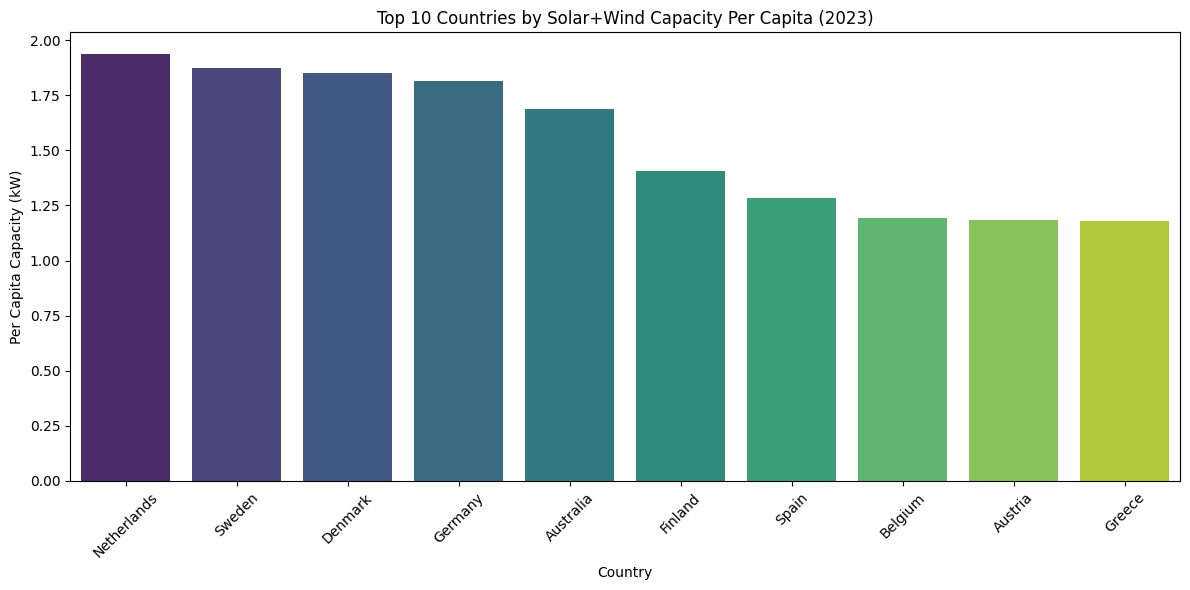

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the latest year with most data
latest_year = data_clean['Year'].max()
top_countries = data_clean[data_clean['Year'] == latest_year].sort_values(by="PerCapita_kW", ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_countries, x="Country", y="PerCapita_kW", palette="viridis")
plt.title(f"Top 10 Countries by Solar+Wind Capacity Per Capita ({latest_year})")
plt.ylabel("Per Capita Capacity (kW)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:
# Load GDP data
gdp = pd.read_csv("gdp_per_capita(current us dollar) (1).csv")

# Clean and reshape
gdp = gdp.drop(columns=["Series Name", "Series Code"])
gdp_long = gdp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP_per_capita")
gdp_long['Year'] = gdp_long['Year'].str.extract(r'(\d{4})').astype(int)
gdp_long['GDP_per_capita'] = pd.to_numeric(gdp_long['GDP_per_capita'], errors='coerce')

In [6]:
final_data = pd.merge(data_clean, gdp_long, on=["Country Code", "Year"], how="left")



C:\Users\Admin\AppData\Local\Temp\ipykernel_5936\497041787.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


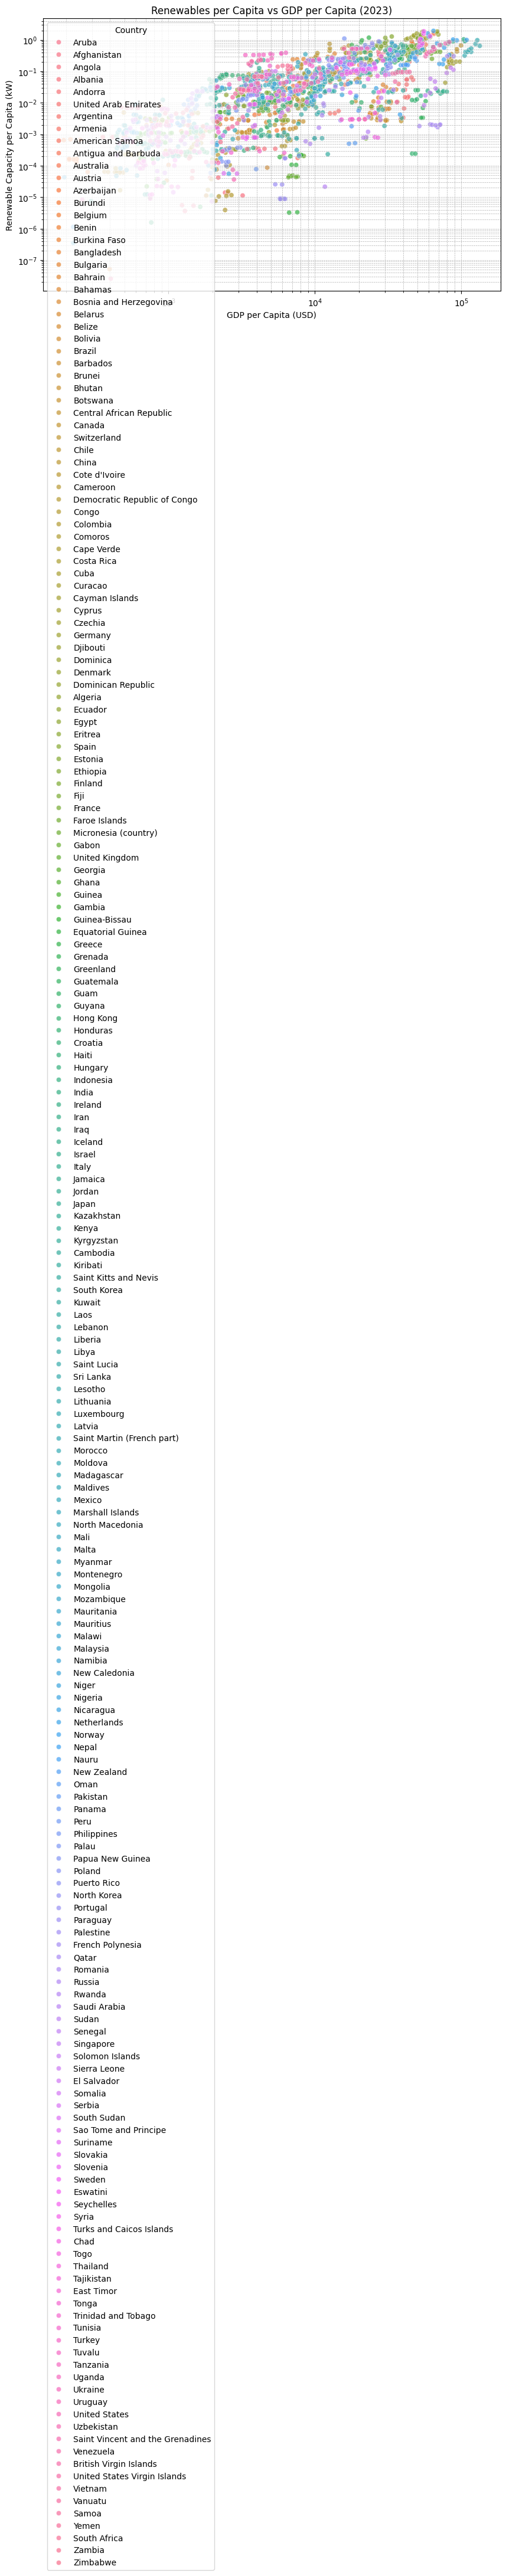

In [7]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=final_data, x="GDP_per_capita", y="PerCapita_kW", hue="Country", alpha=0.7)
plt.title(f"Renewables per Capita vs GDP per Capita ({latest_year})")
plt.xlabel("GDP per Capita (USD)")
plt.ylabel("Renewable Capacity per Capita (kW)")
plt.xscale("log")
plt.yscale("log")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()


In [8]:
C:\Users\Admin\AppData\Local\Temp\ipykernel_13544\497041787.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()

SyntaxError: unexpected character after line continuation character (4143634704.py, line 1)

In [ ]:
top_country = final_data.groupby("Country")["PerCapita_kW"].mean().sort_values(ascending=False).head(1).index[0]

plt.figure(figsize=(10, 5))
subset = final_data[final_data["Country"] == top_country]
sns.lineplot(data=subset, x="Year", y="PerCapita_kW", marker="o")
plt.title(f"{top_country}: Renewable Capacity per Capita Over Time")
plt.ylabel("kW per Capita")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
solar = pd.read_csv("installed-solar-pv-capacity.csv")
solar = solar.rename(columns={"Solar capacity (total) (GW)": "Solar_GW"})
solar = solar[["Entity", "Code", "Year", "Solar_GW"]]
solar.dropna(inplace=True)


In [ ]:
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
wind = wind.rename(columns={"Wind capacity (total) (GW)": "Wind_GW"})
wind = wind[["Entity", "Code", "Year", "Wind_GW"]]
wind.dropna(inplace=True)


In [ ]:
gdp = pd.read_csv("gdp_per_capita(current us dollar) (2).csv")
gdp = gdp.drop(columns=["Series Name", "Series Code"])
gdp_long = gdp.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="GDP_per_capita")
gdp_long["Year"] = gdp_long["Year"].str.extract(r'(\d{4})').astype(int)
gdp_long["GDP_per_capita"] = pd.to_numeric(gdp_long["GDP_per_capita"], errors='coerce')


In [ ]:
population = pd.read_csv("population (1).csv")
population = population.drop(columns=["Series Name", "Series Code"])
pop_long = population.melt(id_vars=["Country Name", "Country Code"], var_name="Year", value_name="Population")
pop_long["Year"] = pop_long["Year"].str.extract(r'(\d{4})').astype(int)
pop_long["Population"] = pd.to_numeric(pop_long["Population"], errors='coerce')


In [ ]:
print("🔆 Solar Capacity (GW)")
print(solar.head())


In [ ]:
print("💨 Wind Capacity (GW)")
print(wind.head())


In [ ]:
print("💰 GDP per Capita (USD)")
print(gdp_long.head())


In [ ]:
print("Solar years:", solar['Year'].min(), "-", solar['Year'].max())
print("Wind years:", wind['Year'].min(), "-", wind['Year'].max())
print("GDP years:", gdp_long['Year'].min(), "-", gdp_long['Year'].max())
print("Population years:", pop_long['Year'].min(), "-", pop_long['Year'].max())


In [ ]:
# Merge solar and wind on Country and Year
renewables = pd.merge(solar, wind, on=["Entity", "Code", "Year"], how="outer")


In [ ]:
# Rename for consistency
gdp_long.rename(columns={"Country Name": "Entity", "Country Code": "Code"}, inplace=True)

# Merge GDP
renewables = pd.merge(renewables, gdp_long, on=["Entity", "Code", "Year"], how="left")


In [ ]:
# Rename for consistency
pop_long.rename(columns={"Country Name": "Entity", "Country Code": "Code"}, inplace=True)

# Merge Population
renewables = pd.merge(renewables, pop_long, on=["Entity", "Code", "Year"], how="left")


In [ ]:
print("📦 Final Merged Dataset Preview")
print(renewables.head())


In [ ]:
# Make sure solar and wind values are numeric
renewables["Solar_GW"] = pd.to_numeric(renewables["Solar_GW"], errors='coerce')
renewables["Wind_GW"] = pd.to_numeric(renewables["Wind_GW"], errors='coerce')
renewables["GDP_per_capita"] = pd.to_numeric(renewables["GDP_per_capita"], errors='coerce')
renewables["Population"] = pd.to_numeric(renewables["Population"], errors='coerce')

# 1. Total Renewable Capacity (GW)
renewables["Total_Renewables_GW"] = renewables["Solar_GW"].fillna(0) + renewables["Wind_GW"].fillna(0)

# 2. Renewable Capacity per Capita (kW)
# Convert GW to kW: 1 GW = 1,000,000 kW
renewables["Renewables_per_capita_kW"] = (renewables["Total_Renewables_GW"] * 1_000_000) / renewables["Population"]

# Optional 3. Log Transforms (useful for scatter plots)
import numpy as np
renewables["log_GDP_per_capita"] = np.log1p(renewables["GDP_per_capita"])
renewables["log_Renewables_per_capita_kW"] = np.log1p(renewables["Renewables_per_capita_kW"])


In [ ]:
renewables[["Entity", "Year", "Solar_GW", "Wind_GW", "Total_Renewables_GW", 
            "Population", "Renewables_per_capita_kW", "GDP_per_capita"]].head()


In [ ]:
renewables_2023 = renewables[renewables["Year"] == 2023].copy()


In [ ]:
renewables_2023[["Entity", "Total_Renewables_GW"]].dropna().head()


In [ ]:
import plotly.express as px

fig = px.choropleth(
    renewables_2023,
    locations="Code",  # ISO 3-letter country codes
    color="Total_Renewables_GW",
    hover_name="Entity",
    color_continuous_scale="Viridis",
    title="🌍 Total Renewable Energy Capacity by Country (2023)",
)

fig.update_layout(geo=dict(showframe=False, showcoastlines=True))
import plotly.io as pio
pio.renderers.default = 'notebook'  # Try 'notebook_connected' or 'iframe' if needed

fig.show()


In [ ]:
# If your dataset has separate columns for Solar_GW, Wind_GW, Hydro_GW:
df['Total_Renewables_GW'] = df[['Solar_GW', 'Wind_GW', 'Hydro_GW']].sum(axis=1)


In [ ]:
%whos


In [ ]:
df = renewables_all  # or whatever your merged DataFrame is

In [ ]:
# 1. Solar Capacity (GW)
solar = pd.read_csv("installed-solar-pv-capacity.csv")
solar = solar.rename(columns={"Entity": "Entity", "Year": "Year", "Installed solar PV capacity (MW)": "Solar_GW"})
solar["Solar_GW"] = solar["Solar_GW"] / 1000  # Convert MW to GW

# 2. Wind Capacity (GW)
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
wind = wind.rename(columns={"Cumulative installed wind energy capacity (GWe)": "Wind_GW"})

# 3. Hydro Capacity (GW)
hydro = pd.read_csv("hydropower-consumption.csv")
hydro = hydro.rename(columns={"Hydropower consumption (TWh)": "Hydro_GW"})  # We'll treat TWh proxy for now


In [ ]:
import pandas as pd

solar = pd.read_csv("installed-solar-pv-capacity.csv")
print(solar.columns)


In [ ]:
import pandas as pd

# 1. Solar Capacity (Already in GW)
solar = pd.read_csv("installed-solar-pv-capacity.csv")
solar = solar.rename(columns={
    "Solar capacity (total) (GW)": "Solar_GW"
})
solar = solar[["Entity", "Code", "Year", "Solar_GW"]]

# 2. Wind Capacity
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
wind = wind.rename(columns={
    "Cumulative installed wind energy capacity (GWe)": "Wind_GW"
})
wind = wind[["Entity", "Code", "Year", "Wind_GW"]]

# 3. Hydropower
hydro = pd.read_csv("hydropower-consumption.csv")
hydro = hydro.rename(columns={
    "Hydropower consumption (TWh)": "Hydro_GW"  # assuming for now; actual column might differ
})
hydro = hydro[["Entity", "Code", "Year", "Hydro_GW"]]


In [ ]:
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
print(wind.columns)


In [ ]:
wind = pd.read_csv("cumulative-installed-wind-energy-capacity-gigawatts.csv")
wind = wind.rename(columns={"Wind capacity (total) (GW)": "Wind_GW"})
wind = wind[["Entity", "Code", "Year", "Wind_GW"]]


In [ ]:
hydro = pd.read_csv("hydropower-consumption.csv")
print(hydro.columns)


In [ ]:
hydro = pd.read_csv("hydropower-consumption.csv")
hydro = hydro.rename(columns={"Electricity from hydro - TWh": "Hydro_TWh"})
hydro = hydro[["Entity", "Code", "Year", "Hydro_TWh"]]

In [ ]:
# Start with solar
renewables_all = solar.copy()

# Merge wind
renewables_all = pd.merge(
    renewables_all, wind, on=["Entity", "Code", "Year"], how="outer"
)

# Merge hydro
renewables_all = pd.merge(
    renewables_all, hydro, on=["Entity", "Code", "Year"], how="outer"
)

# Preview the merged DataFrame
renewables_all.head()


In [ ]:
renewables_all[["Solar_GW", "Wind_GW", "Hydro_TWh"]] = renewables_all[
    ["Solar_GW", "Wind_GW", "Hydro_TWh"]
].fillna(0)


In [ ]:
renewables_all["Hydro_GW"] = renewables_all["Hydro_TWh"] * 0.114


In [ ]:
renewables_all["Total_Renewables_GW"] = (
    renewables_all["Solar_GW"] +
    renewables_all["Wind_GW"] +
    renewables_all["Hydro_GW"]
)


In [ ]:
renewables_all[["Entity", "Year", "Solar_GW", "Wind_GW", "Hydro_GW", "Total_Renewables_GW"]].sort_values(by="Total_Renewables_GW", ascending=False).head(10)


In [ ]:
print(population.columns.tolist())


In [ ]:
population = population.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="Year",
    value_name="Population"
)


In [ ]:
population["Year"] = population["Year"].str.extract(r"(\d{4})").astype(int)


In [ ]:
population = population.rename(columns={
    "Country Name": "Entity",
    "Country Code": "Code"
})


In [ ]:
renewables_all = pd.merge(
    renewables_all, population, on=["Entity", "Code", "Year"], how="left"
)


In [ ]:
gdp = pd.read_csv("gdp_per_capita(current us dollar) (1).csv")


In [ ]:
gdp = gdp.drop(columns=["Series Name", "Series Code"])


In [ ]:
gdp = gdp.melt(
    id_vars=["Country Name", "Country Code"],
    var_name="Year",
    value_name="GDP_per_Capita"
)


In [ ]:
gdp["Year"] = gdp["Year"].str.extract(r"(\d{4})").astype(int)


In [ ]:
gdp = gdp.rename(columns={
    "Country Name": "Entity",
    "Country Code": "Code"
})


In [ ]:
renewables_all = pd.merge(
    renewables_all, gdp, on=["Entity", "Code", "Year"], how="left"
)


In [ ]:
renewables_all.head()

In [ ]:
renewables_all["Total_GW"] = (
    renewables_all["Solar_GW"].fillna(0) +
    renewables_all["Wind_GW"].fillna(0) +
    renewables_all["Hydro_GW"].fillna(0)
)

# Convert GW to kW (1 GW = 1,000,000 kW)
renewables_all["Capacity_per_Capita_kW"] = (
    renewables_all["Total_GW"] * 1_000_000 / renewables_all["Population"]
)


In [ ]:
# Convert Population column to numeric (remove commas and convert to float)
renewables_all["Population"] = pd.to_numeric(renewables_all["Population"], errors='coerce')


In [ ]:
# Calculate total renewable capacity in GW
renewables_all["Total_GW"] = (
    renewables_all["Solar_GW"].fillna(0) +
    renewables_all["Wind_GW"].fillna(0) +
    renewables_all["Hydro_GW"].fillna(0)
)

# Convert GW to kW and compute capacity per capita
renewables_all["Capacity_per_Capita_kW"] = (
    renewables_all["Total_GW"] * 1_000_000 / renewables_all["Population"]
)


In [ ]:
renewables_all[["Entity", "Year", "Total_GW", "Population", "Capacity_per_Capita_kW"]].dropna().head(10)


In [ ]:
map_2023 = renewables_all[renewables_all["Year"] == 2023].copy()


In [ ]:
map_2023 = map_2023.dropna(subset=["Code", "Total_GW"])


In [ ]:
import plotly.express as px

fig = px.choropleth(
    map_2023,
    locations="Code",                # ISO 3-letter country codes
    color="Total_GW",                # Color by total capacity
    hover_name="Entity",            # Show country name on hover
    color_continuous_scale="YlGnBu",
    title="Total Renewable Energy Capacity (GW) by Country in 2023"
)

fig.show()


In [ ]:
top5_2023 = (
    renewables_all[renewables_all["Year"] == 2023]
    .sort_values("Total_GW", ascending=False)
    .head(5)
)["Entity"].tolist()


In [ ]:
trend_data = renewables_all[
    (renewables_all["Entity"].isin(top5_2023)) & 
    (renewables_all["Year"] >= 2010)
]


In [ ]:
import plotly.express as px

fig = px.line(
    trend_data,
    x="Year",
    y="Total_GW",
    color="Entity",
    markers=True,
    title="Renewable Energy Capacity Growth (Top 5 Countries, 2010–2023)",
    labels={"Total_GW": "Total Capacity (GW)"}
)

fig.show()


In [ ]:
global_mix = (
    renewables_all[renewables_all["Year"] >= 2010]
    .groupby("Year")[["Solar_GW", "Wind_GW", "Hydro_GW"]]
    .sum()
    .reset_index()
)


In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=global_mix["Year"],
    y=global_mix["Solar_GW"],
    mode="lines",
    name="Solar",
    stackgroup="one"
))
fig.add_trace(go.Scatter(
    x=global_mix["Year"],
    y=global_mix["Wind_GW"],
    mode="lines",
    name="Wind",
    stackgroup="one"
))
fig.add_trace(go.Scatter(
    x=global_mix["Year"],
    y=global_mix["Hydro_GW"],
    mode="lines",
    name="Hydro",
    stackgroup="one"
))

fig.update_layout(
    title="Global Renewable Energy Mix (2010–2023)",
    xaxis_title="Year",
    yaxis_title="Capacity (GW)",
    legend_title="Source"
)

fig.show()


In [ ]:
# Filter for 2023 data
latest_year = 2023
df_2023 = renewables_all[renewables_all["Year"] == latest_year].copy()

# Remove rows with missing values
df_2023 = df_2023.dropna(subset=["GDP_per_capita", "Population", "Total_Renewable_GW"])

# Calculate renewable capacity per capita (GW per person)
df_2023["Renewables_per_capita"] = df_2023["Total_Renewable_GW"] / df_2023["Population"]


In [ ]:
renewables_all.columns


In [ ]:
import plotly.express as px

# Filter for latest year
df_2023 = renewables_all[renewables_all["Year"] == 2023].copy()

# Drop missing values
df_2023 = df_2023.dropna(subset=["GDP_per_Capita", "Population", "Total_Renewables_GW"])

# Calculate renewable capacity per person (GW per capita)
df_2023["Renewables_per_capita_GW"] = df_2023["Total_Renewables_GW"] / df_2023["Population"]

# Create scatter plot
fig = px.scatter(
    df_2023,
    x="GDP_per_Capita",
    y="Renewables_per_capita_GW",
    text="Entity",
    title="GDP per Capita vs. Renewable Capacity per Capita (2023)",
    labels={
        "GDP_per_Capita": "GDP per Capita (USD)",
        "Renewables_per_capita_GW": "Renewable Capacity per Capita (GW/person)"
    },
    size_max=60,
    template="plotly_white"
)

# Improve layout
fig.update_traces(textposition="top center")
fig.update_layout(height=600)
fig.show()


In [ ]:
# Filter for 2010 and 2023
df_compare = renewables_all[renewables_all["Year"].isin([2010, 2023])].copy()

# Drop rows with missing data
df_compare = df_compare.dropna(subset=["Total_Renewables_GW", "Population"])

# Calculate per capita renewable capacity
df_compare["Renewables_per_capita_GW"] = df_compare["Total_Renewables_GW"] / df_compare["Population"]


In [ ]:
# Pivot to get both years in one row per country
df_pivot = df_compare.pivot_table(
    index=["Entity", "Code"],
    columns="Year",
    values="Renewables_per_capita_GW"
).reset_index()

# Rename columns for clarity
df_pivot.columns.name = None
df_pivot = df_pivot.rename(columns={2010: "2010", 2023: "2023"})

# Drop rows where both years are missing
df_pivot = df_pivot.dropna(subset=["2010", "2023"], how="all")


In [ ]:
print(df_pivot.columns)
print(df_pivot.head())


In [ ]:
top10_2023 = df_pivot.sort_values(by="2023", ascending=False).head(10)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=top10_2023, y="Entity", x="2023", palette="crest")

plt.xlabel("Renewable Capacity per Capita (GW/person)")
plt.ylabel("Country")
plt.title("Top 10 Countries by Per-Capita Renewable Capacity in 2023")
plt.tight_layout()
plt.show()


In [ ]:
%whos


In [ ]:
# Assuming 'renewables_all' is your final, cleaned, and merged DataFrame.
# If 'final_data' is the correct one, replace 'renewables_all' with 'final_data'.
renewables_all.to_csv("final_renewables_dataset.csv", index=False)
print("Saved 'final_renewables_dataset.csv' successfully!")

In [9]:
import pandas as pd

# Option 1: If 'renewables_all' is your final, merged DataFrame
# Try this first if it contains all your data (solar, wind, hydro, gdp, population)
try:
    if 'renewables_all' in globals(): # Check if the variable exists
        main_df = renewables_all
        print("--- Columns in 'renewables_all' ---")
        print(main_df.columns.tolist())
    else:
        print("Variable 'renewables_all' not found. Trying 'final_data'.")
        # Fallback to Option 2 if renewables_all doesn't exist
        if 'final_data' in globals():
            main_df = final_data
            print("--- Columns in 'final_data' ---")
            print(main_df.columns.tolist())
        else:
            print("Neither 'renewables_all' nor 'final_data' found. Please identify your main DataFrame.")
            print("You can use %whos to see all DataFrames in your environment.")

    # If a main_df was identified, let's also check its first few rows and info
    if 'main_df' in locals():
        print("\n--- First 5 rows of the identified DataFrame ---")
        print(main_df.head())
        print("\n--- Info of the identified DataFrame ---")
        main_df.info()

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the DataFrame you intend to check (e.g., 'renewables_all' or 'final_data')")
    print("was created by running all preceding cells in your notebook (Kernel -> Restart & Run All).")

# --- IMPORTANT: Once you see the column list, manually note down the exact names ---
# --- for the categories below and provide them to me. ---

print("\n--- Based on the columns above, please identify the EXACT names for: ---")
print("1. Country/Entity Column Name:")
print("2. Year Column Name:")
print("3. Solar Capacity Column Name (e.g., Solar_TWh, Solar_GW):")
print("4. Wind Capacity Column Name (e.g., Wind_TWh, Wind_GW):")
print("5. Hydro Capacity Column Name (e.g., Hydro_TWh, Hydro_GW):")
print("6. GDP per Capita Column Name:")
print("7. Population Column Name:")
print("8. Per-Capita Renewable Capacity Column Name (if calculated in this DataFrame):")
print("   (If not, I can calculate it in the app if you provide total capacity and population columns)")


Variable 'renewables_all' not found. Trying 'final_data'.
--- Columns in 'final_data' ---
['Country', 'Country Code', 'Year', 'Solar_GW', 'Wind_GW', 'Country Name_x', 'Population', 'Total_GW', 'PerCapita_kW', 'Country Name_y', 'GDP_per_capita']

--- First 5 rows of the identified DataFrame ---
  Country Country Code  Year  Solar_GW  Wind_GW Country Name_x  Population  \
0   Aruba          ABW  2015  0.006100     0.03          Aruba    107906.0   
1   Aruba          ABW  2016  0.007251     0.03          Aruba    108727.0   
2   Aruba          ABW  2017  0.007304     0.03          Aruba    108735.0   
3   Aruba          ABW  2018  0.014804     0.03          Aruba    108908.0   
4   Aruba          ABW  2019  0.014804     0.03          Aruba    109203.0   

   Total_GW  PerCapita_kW Country Name_y  GDP_per_capita  
0  0.036100      0.334550          Aruba    27458.225331  
1  0.037251      0.342610          Aruba    27441.529662  
2  0.037304      0.343073          Aruba    28440.051964  
